<a href="https://colab.research.google.com/github/emerymoriconi/processamento-digital-de-imagens/blob/main/Trabalho_Final_PDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade Prática 03 -- Processamento Digital de Imagens
Autores:
Émery Freitas Moriconi e
Raffael Ferreira Fernandes

Curso: Ciência da Computação - CCN

Universidade Federal do Piauí

Teresina, 2024

# **0.0) PRÉ-DEFINIÇÕES E IMPORTS**

In [ ]:
# Imports necessários para utilizar nas aplicações

import numpy as np
from numpy import array
import cv2


from skimage import morphology
from google.colab.patches import cv2_imshow

# **1.0) PREPARANDO A IMAGEM**

In [ ]:
# Leitura da imagem
img = cv2.imread("imagem.JPG")


In [ ]:
# Redimensionamento da imagem, proporcao 3:4
new_width = 480
new_heigth = 640
new_size = (new_width, new_heigth)

resize = cv2.resize(img, new_size)

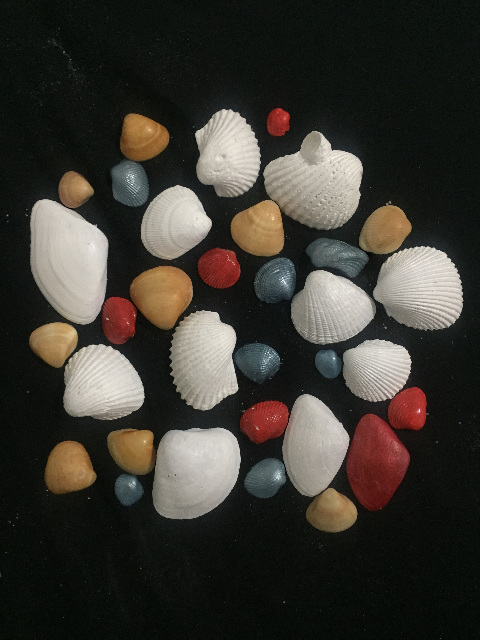

In [ ]:
# Imagem original
cv2_imshow(resize)

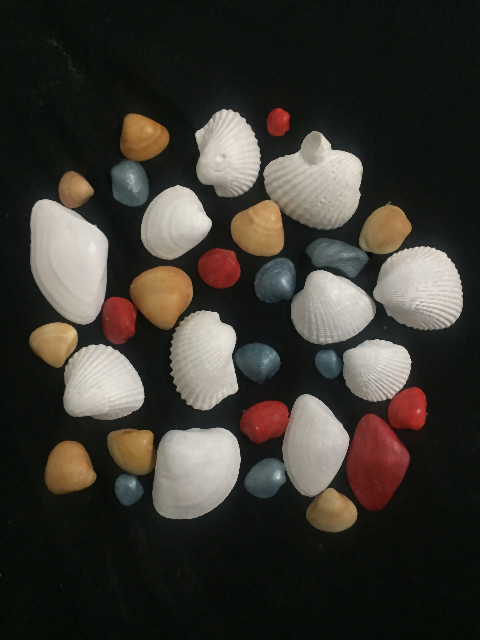

In [ ]:
# Limpando ruídos da imagem com filtro da mediana
mediana = cv2.medianBlur(resize, 3)
cv2_imshow(mediana)

# **2.0) APLICAÇÕES DE REALCE NA IMAGEM**

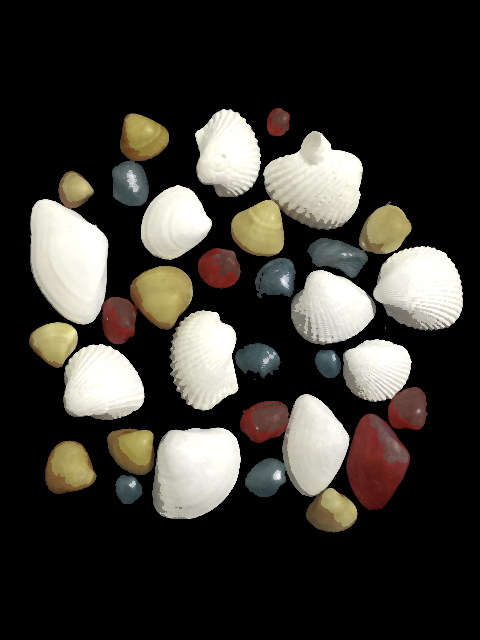

In [ ]:
def realce_cores(imagem):
    # Realce de cores seguindo o algoritmo descrito
    altura, largura, _ = imagem.shape

    nova_imagem = imagem.copy()

    for y in range(altura):
        for x in range(largura):
            # Obtenha os valores de pixel nos canais BGR
            azul, verde, vermelho = imagem[y, x]

            # Verifique se o pixel é preto (valores muito baixos em todos os canais)
            if azul < 60 and verde < 60 and vermelho < 60:
                # Ajuste os valores para tornar o pixel ainda mais escuro
                nova_imagem[y, x] = [0, 0, 0]
            else:
                # Verifique se há um valor muito alto em um ou dois canais
                if azul > 130 or verde > 130 or vermelho > 130:
                    # Ajuste proporcionalmente os canais com valores muito altos
                    min_value = max(azul, verde, vermelho)
                    ratio = ( 255 / min_value ) * 0.2
                    nova_imagem[y, x] = [min(azul + int(azul * ratio), 255),
                                     min(verde + int(verde * ratio), 255),
                                     min(verde + int(vermelho * ratio), 255)]

    return nova_imagem

# Aplique o realce de cores
imagem_realce = realce_cores(mediana)
cv2_imshow(imagem_realce)

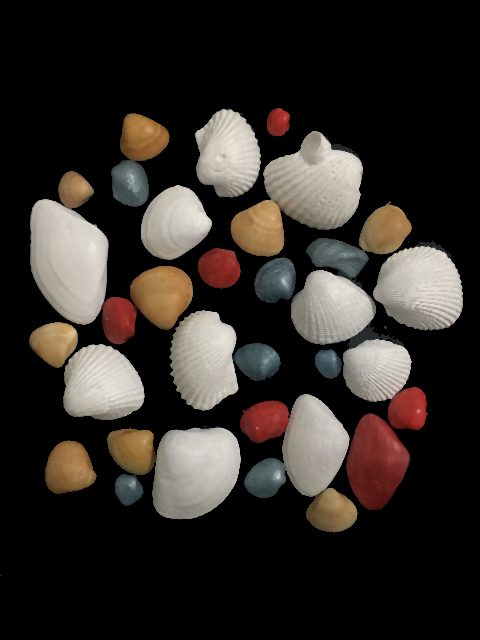

In [ ]:
# Removendo o fundo da imagem
def identificar_e_remover_fundo(imagem, limiar=(40, 55, 55)):
    """
    Identifica os pixels de fundo com base no limiar nos 3 canais de cores e os torna pretos.

    :param imagem: imagem colorida (numpy array)
    :param limiar: limiar para cada canal de cor (B, G, R)
    :return: imagem com o fundo removido
    """
    altura, largura, _ = imagem.shape
    imagem_sem_fundo = np.copy(imagem)

    for y in range(altura):
        for x in range(largura):
            pixel = imagem[y, x]
            # Verifica se o pixel é considerado fundo com base no limiar
            if all(p <= lim for p, lim in zip(pixel, limiar)):
                # Se for fundo, torna o pixel completamente preto
                imagem_sem_fundo[y, x] = [0, 0, 0]

    return imagem_sem_fundo

imagem_sem_fundo = identificar_e_remover_fundo(mediana)
cv2_imshow(imagem_sem_fundo)

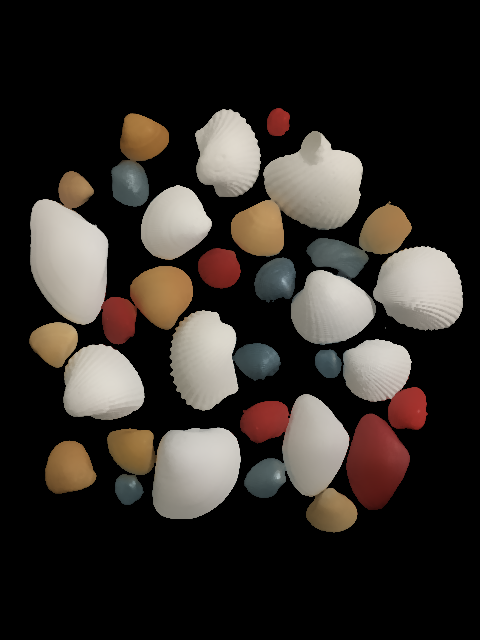

In [ ]:
# Realce de cores com filtro bilateral
imagem_filtrada = cv2.bilateralFilter(imagem_sem_fundo, d=30, sigmaColor=70, sigmaSpace=80)
imagem_filtrada = identificar_e_remover_fundo(imagem_filtrada, (45, 45, 45))
cv2_imshow(imagem_filtrada)

# **3.0) APLICAÇÃO DE MÁSCARAS DE CORES**

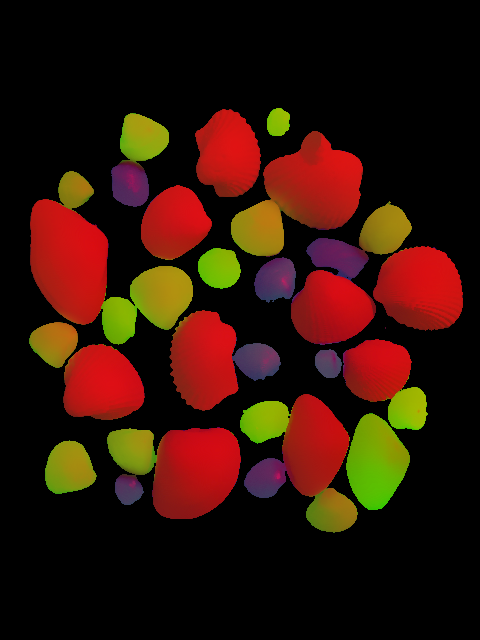

In [ ]:
# Conversão da imagem de BGR para HSV
img_hsv = cv2.cvtColor(imagem_filtrada, cv2.COLOR_BGR2HSV)
cv2_imshow(img_hsv)

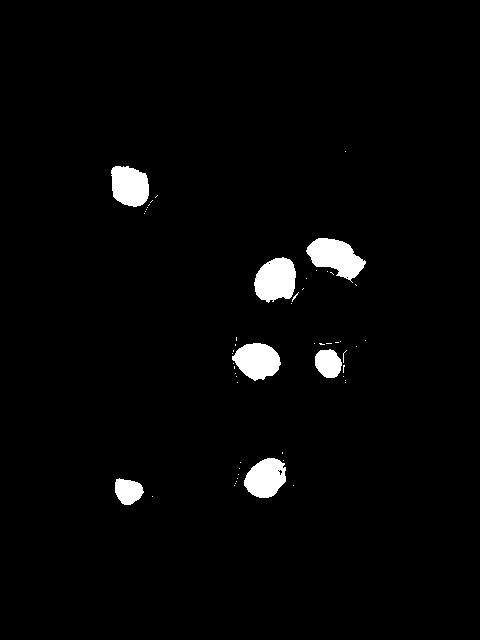

In [ ]:
# Máscara para identificar objetos azuis
masc_azul = cv2.inRange(img_hsv, (80, 15, 10), (150, 255, 255))
cv2_imshow(masc_azul)

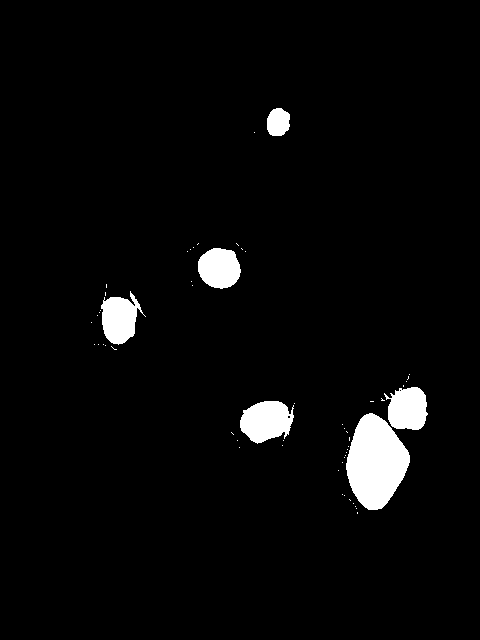

In [ ]:
# Máscara para identificar objetos vermelhos
masc_vermelha1 = cv2.inRange(img_hsv, (170, 20, 60), (180, 255, 255))
masc_vermelha2 = cv2.inRange(img_hsv, (0, 20, 20), (10, 255, 255))
masc_vermelha = cv2.bitwise_or(masc_vermelha1, masc_vermelha2)
cv2_imshow(masc_vermelha)

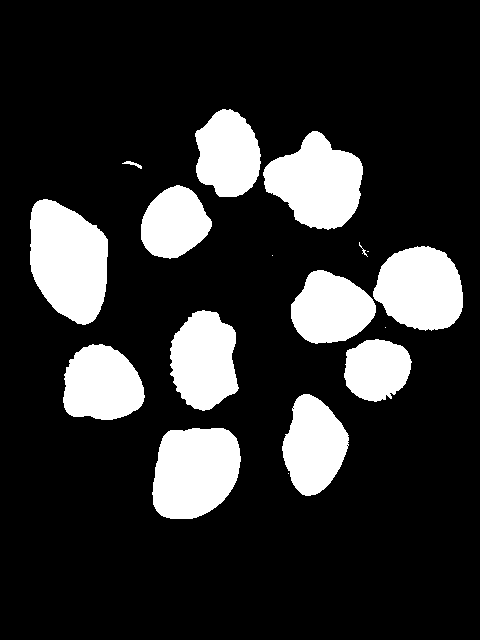

In [ ]:
# Máscara para identificar objetos brancos
masc_branca = cv2.inRange(img_hsv, (10, 0, 80), (40, 60, 255))
cv2_imshow(masc_branca)

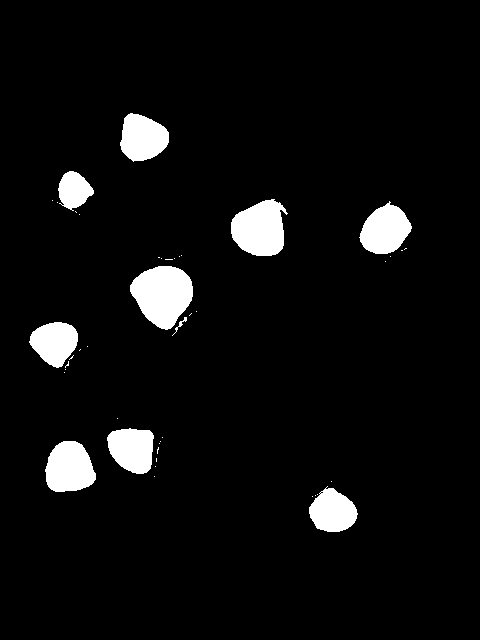

In [ ]:
# Máscara para identificar objetos amarelos
masc_amarela = cv2.inRange(img_hsv, (10, 75, 90), (25, 255, 255))
cv2_imshow(masc_amarela)

In [ ]:
# filtros erosao nas mascaras, pois todas elas tem ruidos (pixels que nao se enquandram com o que queremos)
# kernel para usar na erosao e dilatacao
kernel = np.ones((3,3), np.uint8)

# abertura nas máscaras
blue_erode= cv2.erode(masc_azul,kernel,iterations=3)
yellow_erode = cv2.erode(masc_amarela,kernel,iterations=3)
red_erode = cv2.erode(masc_vermelha,kernel,iterations=5)
white_erode = cv2.erode(masc_branca,kernel,iterations=2)

In [ ]:
# filtros de dilatacao nas mascaras
blue_dilate = cv2.dilate(blue_erode,kernel,iterations=3)
yellow_dilate = cv2.dilate(yellow_erode,kernel,iterations=3)
red_dilate = cv2.dilate(red_erode,kernel,iterations=5)
white_dilate = cv2.dilate(white_erode,kernel,iterations=2)

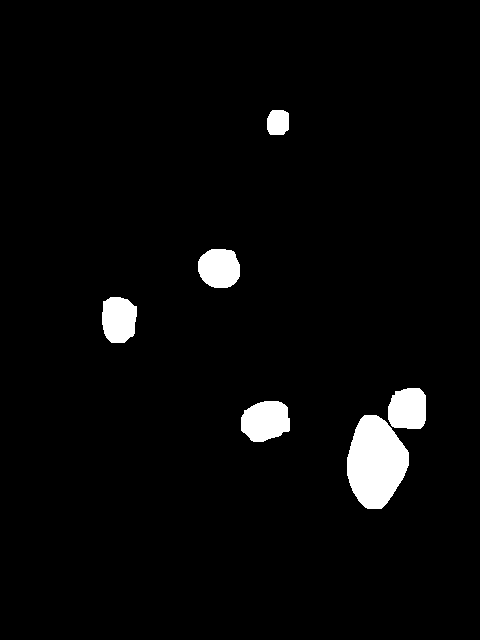

In [ ]:
cv2_imshow(red_dilate)

# **4.0) CLASSIFICAÇÃO DOS ELEMENTOS DA IMAGEM**

In [ ]:
# Achando os contornos das conchas conforme as máscaras de cores e escrita na imagem da quantidade de conchas de cada cor foram contados
cont = 0
name = ["Azul","Amarelo","Vermelho","Branco"]
color = [(255,0,0),(0,255,255),(0,0,255),(255, 255, 255)]
array_masks = [blue_dilate, yellow_dilate, red_dilate, white_dilate]
img_classificada = resize.copy()
for i in range(len(array_masks)):
    qtd = 0
    contornos,hierarquia = cv2.findContours(array_masks[i],cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    for x in range(len(contornos)):
        area = cv2.contourArea(contornos[x])
        if(area>400):
            #desenhando os contornos
            desenho_contorno = cv2.drawContours(img_classificada,contornos,x,color[i],2)
            qtd +=1
    cv2.putText(img_classificada,name[i] + ": "+ str(qtd), (10+cont,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,255,255),1, cv2.LINE_AA)
    cont+=110

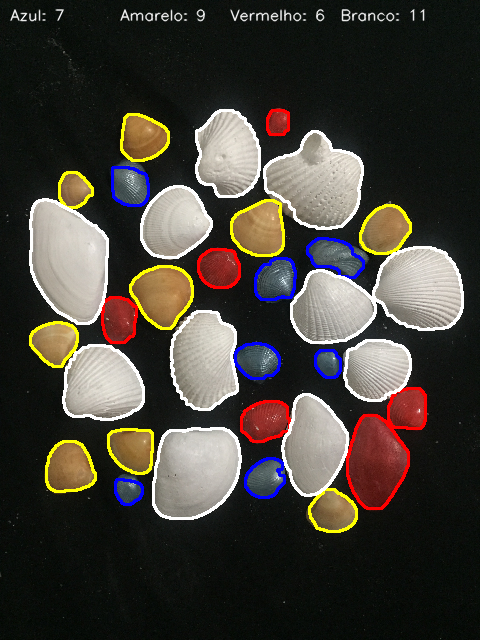

In [ ]:
cv2_imshow(img_classificada)

# **4.2) CLASSIFICANDO POR TAMANHO**

In [ ]:
def uniao_imagens(imagem1, imagem2):
    """
    Realiza a união entre duas imagens de dimensões iguais.

    Parâmetros:
    - imagem1: Primeira imagem (numpy array).
    - imagem2: Segunda imagem (numpy array).

    Retorna:
    - nova_imagem: Imagem resultante da união das duas imagens de entrada.
    """
    # Verifica se as imagens têm as mesmas dimensões
    if imagem1.shape != imagem2.shape:
        raise ValueError("As imagens devem ter as mesmas dimensões.")

    # Realiza a união pixel a pixel das duas imagens
    nova_imagem = np.maximum(imagem1, imagem2)

    return nova_imagem

In [ ]:
mascs_azul_verm = uniao_imagens(blue_dilate, red_dilate)
mascs_branc_amar = uniao_imagens(yellow_dilate, white_dilate)
uniao_masks = uniao_imagens(mascs_azul_verm, mascs_branc_amar)

cv2_imshow(uniao_masks)

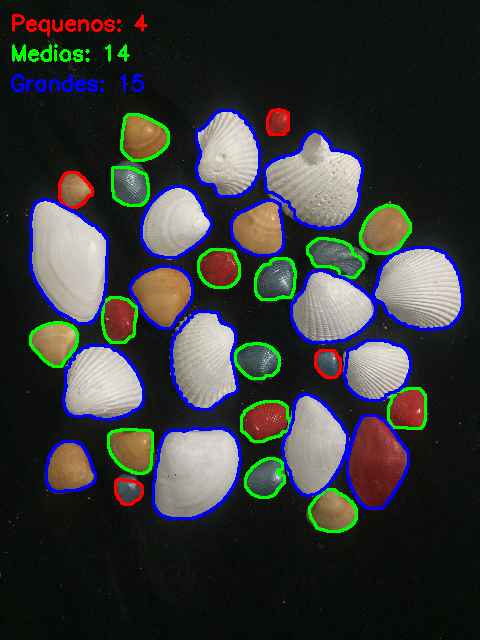

In [ ]:
array_masks = [blue_dilate, yellow_dilate, red_dilate, white_dilate]
name = ["Pequenos", "Médios", "Grandes"]

# Definir limites para categorizar os objetos como pequenos, médios e grandes
limite_pequeno = 1000
limite_medio = 1800

# Iterar sobre os contornos e classificar os objetos pelo tamanho
objetos_pequenos = []
objetos_medios = []
objetos_grandes = []

for i in range(len(array_masks)):
    contornos,hierarquia = cv2.findContours(array_masks[i],cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    for contorno in contornos:
        area = cv2.contourArea(contorno)
        if area < 200:
          pass
        if area < limite_pequeno:
            objetos_pequenos.append(contorno)
        elif area < limite_medio:
            objetos_medios.append(contorno)
        else:
            objetos_grandes.append(contorno)


imagem_colorida = resize.copy()
# Desenhar os contornos classificados em diferentes cores
cv2.drawContours(imagem_colorida, objetos_pequenos, -1, (0, 0, 255), 2)
cv2.drawContours(imagem_colorida, objetos_medios, -1, (0, 255, 0), 2)
cv2.drawContours(imagem_colorida, objetos_grandes, -1, (255, 0, 0), 2)

cv2.putText(imagem_colorida, f"Pequenos: {len(objetos_pequenos)}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
cv2.putText(imagem_colorida, f"Medios: {len(objetos_medios)}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
cv2.putText(imagem_colorida, f"Grandes: {len(objetos_grandes)}", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

cv2_imshow(imagem_colorida)

# **5.0) OUTRAS TÉCNICAS**

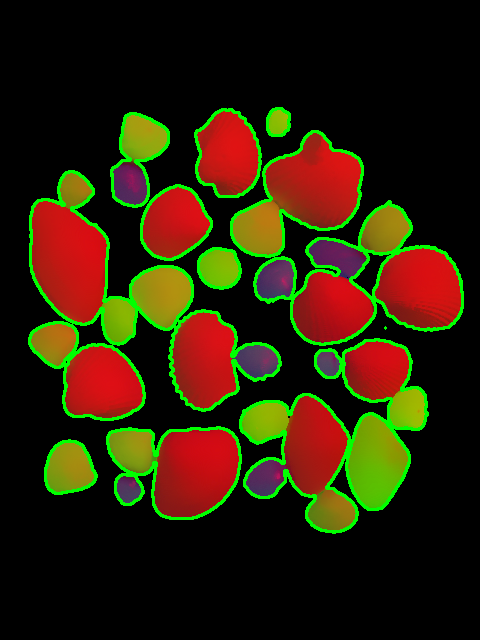

In [ ]:
# Dividir a imagem nos canais de cor BGR
canal_azul, canal_verde, canal_vermelho = cv2.split(imagem_filtrada)

# Aplicar a limiarização em cada canal de cor
limiar, mascara_azul = cv2.threshold(canal_azul, 40, 255, cv2.THRESH_BINARY)
limiar, mascara_verde = cv2.threshold(canal_verde, 140, 255, cv2.THRESH_BINARY)
limiar, mascara_vermelha = cv2.threshold(canal_vermelho, 40, 255, cv2.THRESH_BINARY)

# Combinar as máscaras de limiarização
mascara_final = cv2.bitwise_or(mascara_azul, cv2.bitwise_or(mascara_verde, mascara_vermelha))

# Encontrar os contornos na imagem segmentada
contornos, _ = cv2.findContours(mascara_final, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Desenhar os contornos na imagem original
imagem_segmentada = img_hsv.copy()
cv2.drawContours(imagem_segmentada, contornos, -1, (0, 255, 0), 2)

# Mostrar a imagem segmentada
cv2_imshow(imagem_segmentada)

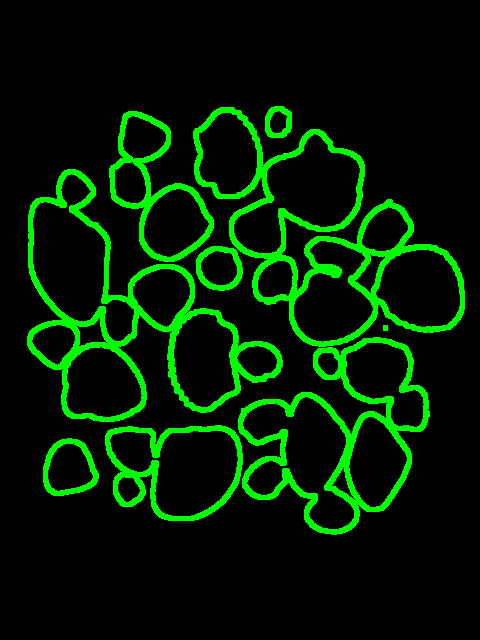

In [ ]:
img_conts = np.zeros((640,480,3), np.uint8)
cv2.drawContours(img_conts, contornos, -1, (0, 255, 0), 1)

kernel = np.ones((3,3),np.uint8)
dilated_img = cv2.dilate(img_conts, kernel, iterations = 2)
cv2_imshow(dilated_img)

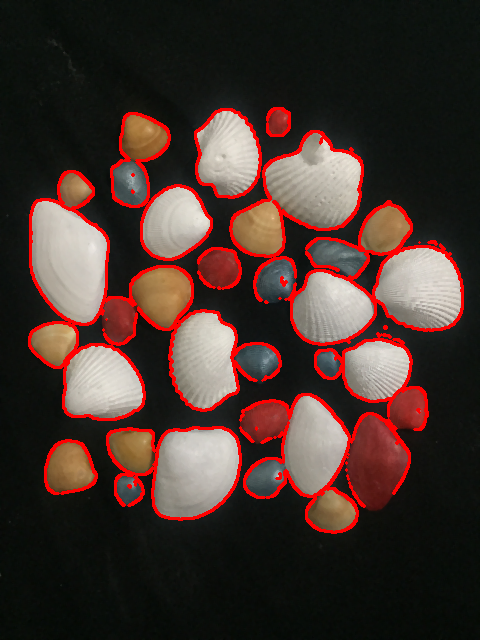

In [ ]:
# Converter a imagem para escala de cinza
imagem_cinza = cv2.cvtColor(imagem_sem_fundo, cv2.COLOR_BGR2GRAY)

# Aplicar o detector de bordas Canny
bordas = cv2.Canny(imagem_cinza, 230, 240)  # Você pode ajustar os valores de limiar conforme necessário

# Encontrar os contornos na imagem de bordas
contornos, _ = cv2.findContours(bordas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Desenhar os contornos na imagem original
imagem_segmentada = mediana.copy()
cv2.drawContours(imagem_segmentada, contornos, -1, (0, 0, 255), 2)

cv2_imshow(imagem_segmentada)

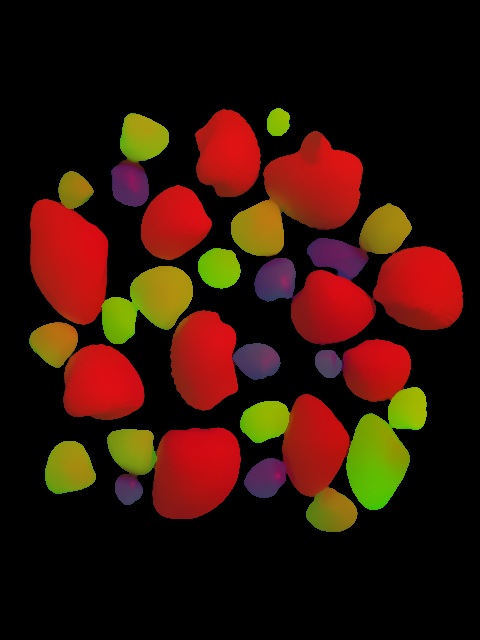

In [ ]:
mediana_hsv = cv2.medianBlur(img_hsv, 5)
cv2_imshow(mediana_hsv)

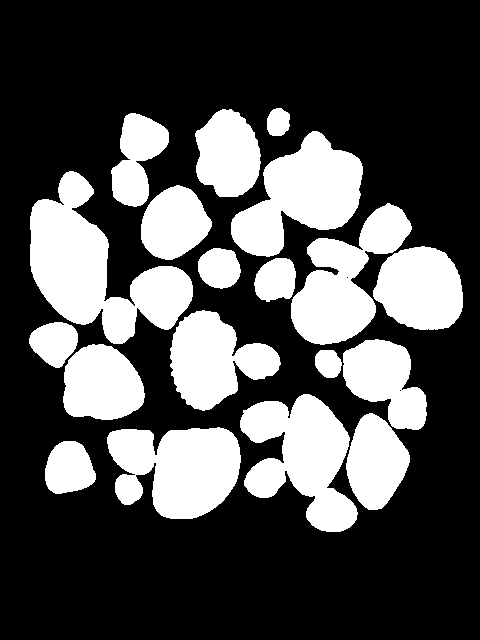

In [ ]:
def aplicacoes(imagem, kernel_size, iterations):
  imagem_abertura = imagem
  for i in range(iterations):
    imagem_erodida = cv2.erode(imagem_abertura, kernel, iterations=1)
    imagem_abertura = cv2.dilate(imagem_erodida, kernel, iterations=1)
  return imagem_abertura

def abertura(imagem, kernel_size=(3, 3)):
    """
    Aplica a operação de abertura na imagem.

    :param imagem: imagem binária (preto e branco)
    :param kernel_size: tamanho do kernel para erosão e dilatação
    :return: imagem após a operação de abertura
    """
    # Define o kernel para erosão e dilatação
    kernel = np.ones(kernel_size, np.uint8)

    # Erosão seguida de dilatação
    imagem_abertura = aplicacoes(imagem, kernel_size, 5)

    return imagem_abertura

imagem_gray = cv2.cvtColor(imagem_filtrada, cv2.COLOR_BGR2GRAY)

# Binariza a imagem para ter um fundo preto e objetos coloridos
_, imagem_binaria = cv2.threshold(imagem_gray, 1, 255, cv2.THRESH_BINARY)

# Aplica a operação de abertura
imagem_abertura = abertura(imagem_binaria)


cv2_imshow(imagem_abertura)

CANNY COM ABERTURAS E FECHAMENTOS

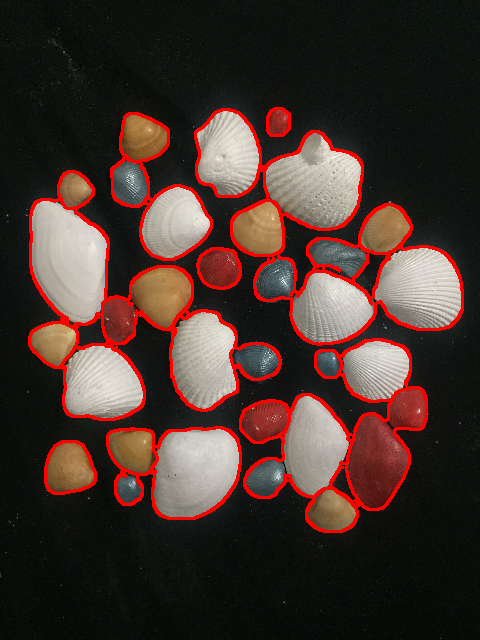

In [ ]:
# Converter a imagem para escala de cinza
imagem_cinza = cv2.cvtColor(mediana_hsv, cv2.COLOR_BGR2GRAY)

# Suavizar a imagem para reduzir o ruído
imagem_suavizada = cv2.GaussianBlur(imagem_cinza, (5, 5), 0)

# Realizar múltiplas operações de abertura para separar objetos próximos
imagem_abertura = imagem_suavizada.copy()
for i in range(20):  # Você pode ajustar o número de vezes que deseja realizar a abertura
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  # Defina o tamanho do kernel conforme necessário
    imagem_abertura = cv2.morphologyEx(imagem_abertura, cv2.MORPH_OPEN, kernel)

# Aplicar uma operação de fechamento para preencher quaisquer lacunas restantes
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  # Defina o tamanho do kernel conforme necessário
imagem_fechamento = cv2.morphologyEx(imagem_abertura, cv2.MORPH_CLOSE, kernel)

# Ajustar os parâmetros do filtro Canny
limiar_inferior = 30
limiar_superior = 80
bordas = cv2.Canny(imagem_fechamento, limiar_inferior, limiar_superior)

# Encontrar os contornos na imagem de bordas
contornos, _ = cv2.findContours(bordas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Desenhar os contornos na imagem original
imagem_segmentada = resize.copy()
cv2.drawContours(imagem_segmentada, contornos, -1, (0, 0, 255), 2)

cv2_imshow(imagem_segmentada)

In [ ]:
# Inicialize contadores para cada cor
contagem_vermelhos = 0
contagem_azuis = 0
contagem_amarelos = 0
contagem_brancos = 0

# Iterar sobre todos os contornos encontrados
for contorno in contornos:
    # Calcular o centro do contorno
    momento = cv2.moments(contorno)
    if momento["m00"] != 0:
        centro_x = int(momento["m10"] / momento["m00"])
        centro_y = int(momento["m01"] / momento["m00"])
    else:
        centro_x, centro_y = 0, 0

    # Verificar a cor do objeto no centro do contorno
    cor_pixel = img_hsv[centro_y, centro_x]
    hue = cor_pixel[0]
    saturacao = cor_pixel[1]
    valor = cor_pixel[2]

    # Determinar a cor com base no espaço de cor HSV
    if (hue >= 0 and hue <= 10) or (hue >= 170 and hue <= 180):  # vermelho
        contagem_vermelhos += 1
    elif hue >= 90 and hue <= 130:  # azul
        contagem_azuis += 1
    elif hue >= 20 and hue <= 40:   # amarelo
        contagem_amarelos += 1
    elif saturacao <= 50 and valor >= 200:  # branco
        contagem_brancos += 1

# Exibir os resultados
print("Número de objetos vermelhos:", contagem_vermelhos)
print("Número de objetos azuis:", contagem_azuis)
print("Número de objetos amarelos:", contagem_amarelos)
print("Número de objetos brancos:", contagem_brancos)

Número de objetos vermelhos: 21
Número de objetos azuis: 6
Número de objetos amarelos: 5
Número de objetos brancos: 3


CANNY COM ABERTURAS

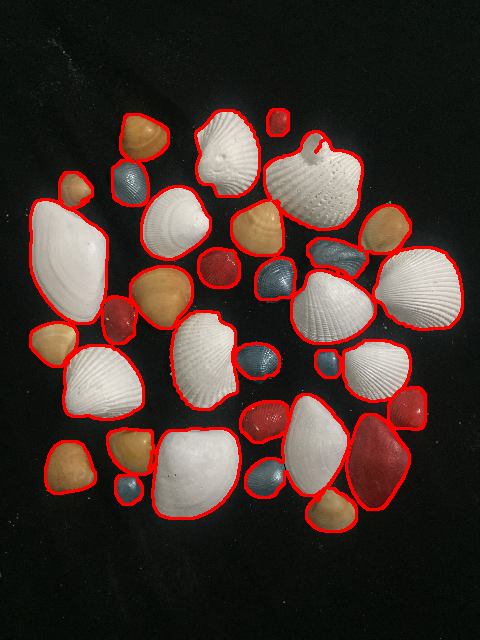

In [ ]:
# Converter a imagem para escala de cinza
imagem_cinza = cv2.cvtColor(imagem_filtrada, cv2.COLOR_RGB2GRAY)

# Suavizar a imagem para reduzir o ruído
#imagem_suavizada = cv2.GaussianBlur(imagem_cinza, (5, 5), 0)

# Realizar múltiplas operações de abertura para separar objetos próximos
imagem_abertura = imagem_cinza.copy()
for i in range(120):  # Você pode ajustar o número de vezes que deseja realizar a abertura
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))  # Defina o tamanho do kernel conforme necessário
    imagem_abertura = cv2.morphologyEx(imagem_abertura, cv2.MORPH_OPEN, kernel)

# Ajustar os parâmetros do filtro Canny
limiar_inferior = 50
limiar_superior = 150
bordas = cv2.Canny(imagem_abertura, limiar_inferior, limiar_superior)

# Encontrar os contornos na imagem de bordas
contornos, _ = cv2.findContours(bordas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Desenhar os contornos na imagem original
imagem_segmentada = resize.copy()
cv2.drawContours(imagem_segmentada, contornos, -1, (0, 0, 255), 2)

cv2_imshow(imagem_segmentada)

In [ ]:
# Inicialize contadores para cada cor
contagem_vermelhos = 0
contagem_azuis = 0
contagem_amarelos = 0
contagem_brancos = 0

# Iterar sobre todos os contornos encontrados
for contorno in contornos:
    # Calcular o centro do contorno
    momento = cv2.moments(contorno)
    if momento["m00"] != 0:
        centro_x = int(momento["m10"] / momento["m00"])
        centro_y = int(momento["m01"] / momento["m00"])
    else:
        centro_x, centro_y = 0, 0

    # Verificar a cor do objeto no centro do contorno
    cor_pixel = img_hsv[centro_y, centro_x]
    hue = cor_pixel[0]
    saturacao = cor_pixel[1]
    valor = cor_pixel[2]

    # Determinar a cor com base no espaço de cor HSV
    if (hue >= 0 and hue <= 10) or (hue >= 170 and hue <= 180):  # vermelho
        contagem_vermelhos += 1
    elif hue >= 90 and hue <= 130:  # azul
        contagem_azuis += 1
    elif hue >= 20 and hue <= 40:   # amarelo
        contagem_amarelos += 1
    elif saturacao <= 50 and valor >= 180:  # branco
        contagem_brancos += 1

# Exibir os resultados
print("Número de objetos vermelhos:", contagem_vermelhos)
print("Número de objetos azuis:", contagem_azuis)
print("Número de objetos amarelos:", contagem_amarelos)
print("Número de objetos brancos:", contagem_brancos)

Número de objetos vermelhos: 12
Número de objetos azuis: 6
Número de objetos amarelos: 4
Número de objetos brancos: 6


SOMENTE CANNY

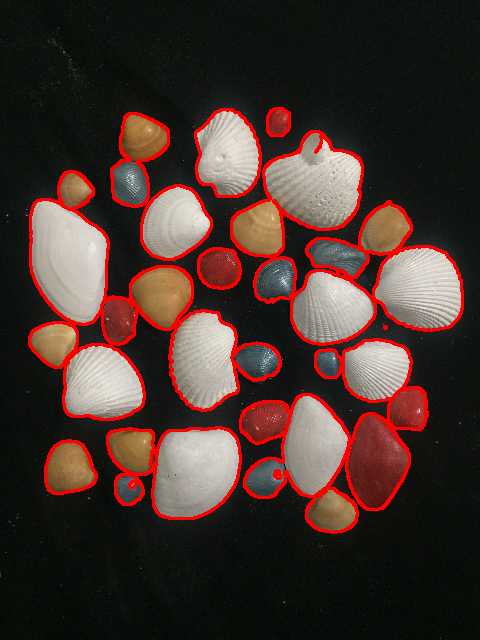

In [ ]:
# Converter a imagem para escala de cinza
imagem_cinza = cv2.cvtColor(imagem_filtrada, cv2.COLOR_BGR2GRAY)

# Aplicar o detector de bordas Canny
bordas = cv2.Canny(imagem_cinza, 100, 200)  # Você pode ajustar os valores de limiar conforme necessário

# Encontrar os contornos na imagem de bordas
contornos, _ = cv2.findContours(bordas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Desenhar os contornos na imagem original
imagem_segmentada = resize.copy()
cv2.drawContours(imagem_segmentada, contornos, -1, (0, 0, 255), 2)

cv2_imshow(imagem_segmentada)

In [ ]:
# Inicialize contadores para cada cor
contagem_vermelhos = 0
contagem_azuis = 0
contagem_amarelos = 0
contagem_brancos = 0

# Iterar sobre todos os contornos encontrados
for contorno in contornos:
    # Calcular o centro do contorno
    momento = cv2.moments(contorno)
    if momento["m00"] != 0:
        centro_x = int(momento["m10"] / momento["m00"])
        centro_y = int(momento["m01"] / momento["m00"])
    else:
        centro_x, centro_y = 0, 0

    # Verificar a cor do objeto no centro do contorno
    cor_pixel = img_hsv[centro_y, centro_x]
    hue = cor_pixel[0]
    saturacao = cor_pixel[1]
    valor = cor_pixel[2]

    # Determinar a cor com base no espaço de cor HSV
    if (hue >= 0 and hue <= 10) or (hue >= 170 and hue <= 180):  # vermelho
        contagem_vermelhos += 1
    elif hue >= 90 and hue <= 130:  # azul
        contagem_azuis += 1
    elif hue >= 20 and hue <= 40:   # amarelo
        contagem_amarelos += 1
    elif saturacao <= 50 and valor >= 200:  # branco
        contagem_brancos += 1

# Exibir os resultados
print("Número de objetos vermelhos:", contagem_vermelhos)
print("Número de objetos azuis:", contagem_azuis)
print("Número de objetos amarelos:", contagem_amarelos)
print("Número de objetos brancos:", contagem_brancos)

Número de objetos vermelhos: 13
Número de objetos azuis: 7
Número de objetos amarelos: 5
Número de objetos brancos: 3


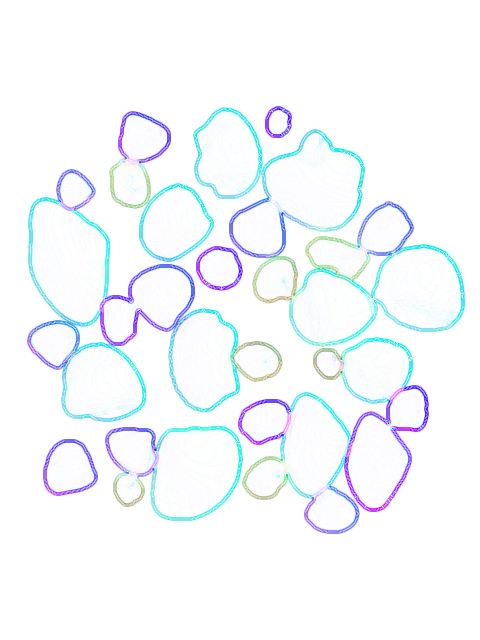

In [ ]:
# Aplicar a suavização Gaussiana
imagem_suavizada = cv2.GaussianBlur(mediana_hsv, (3, 3), 0)

# Aplicar o filtro Laplaciano da Gaussiana (LoG)
imagem_log = cv2.Laplacian(imagem_suavizada, cv2.CV_64F, ksize=3)

# Converter para uint8 e tornar os valores absolutos
imagem_log = np.uint8(np.absolute(imagem_log))

# Inverter os valores para realçar os objetos em relação ao fundo preto
imagem_log_invertida = 255 - imagem_log

# Mostrar a imagem resultante
cv2_imshow(imagem_log_invertida)

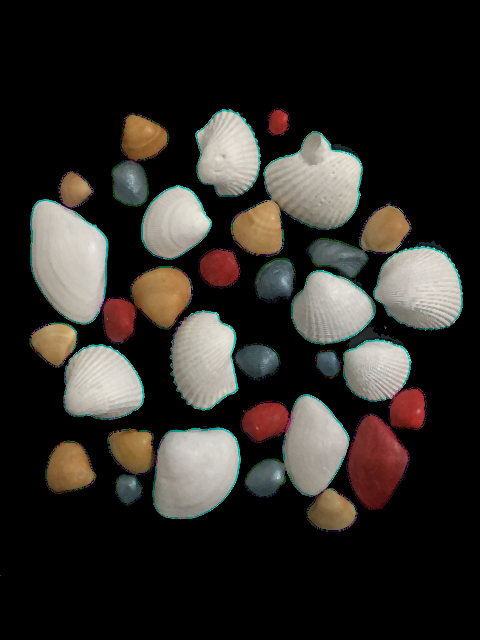

In [ ]:
# Converter a imagem de realce para o mesmo número de canais que a imagem original
#imagem_realce_invertida = cv2.cvtColor(imagem_log_invertida, cv2.COLOR_GRAY2BGR)

# Aplicar a operação bitwise AND entre a imagem original e a imagem de realce
imagem_resultante = cv2.bitwise_and(imagem_sem_fundo, imagem_log_invertida)

cv2_imshow(imagem_resultante)

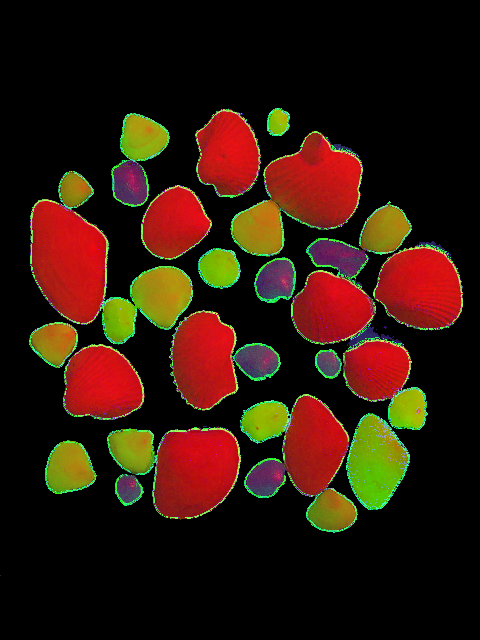

In [ ]:
# Conversão da imagem de BGR para HSV
img_res_hsv = cv2.cvtColor(imagem_resultante, cv2.COLOR_BGR2HSV)
cv2_imshow(img_res_hsv)

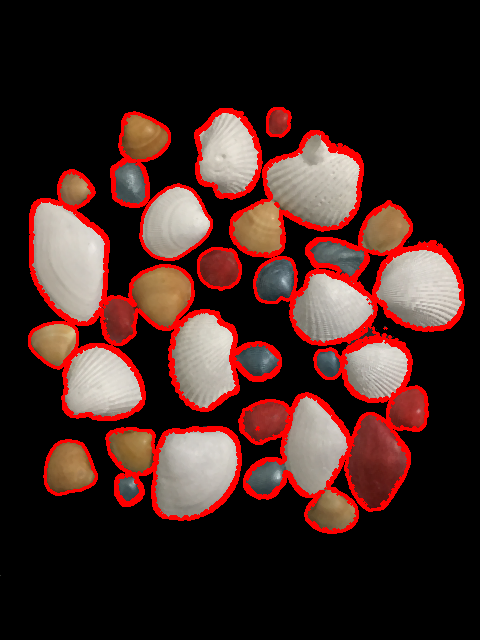

In [ ]:
# Converter a imagem para escala de cinza
imagem_cinza = cv2.cvtColor(img_res_hsv, cv2.COLOR_BGR2GRAY)

# Aplicar o detector de bordas Canny
bordas = cv2.Canny(imagem_cinza, 220, 235)  # Você pode ajustar os valores de limiar conforme necessário

# Encontrar os contornos na imagem de bordas
contornos, _ = cv2.findContours(bordas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Desenhar os contornos na imagem original
imagem_segmentada = imagem_sem_fundo.copy()
cv2.drawContours(imagem_segmentada, contornos, -1, (0, 0, 255), 2)

cv2_imshow(imagem_segmentada)

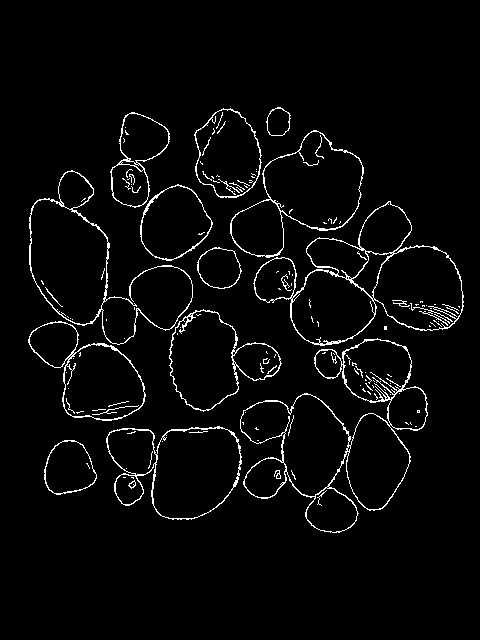

In [ ]:
def apply_canny_on_color_image(image, low_threshold, high_threshold):
    # Separa a imagem em canais de cor (BGR)
    b, g, r = cv2.split(image)

    # Aplica o operador de Canny em cada canal
    edges_b = cv2.Canny(b, low_threshold, high_threshold)
    edges_g = cv2.Canny(g, low_threshold, high_threshold)
    edges_r = cv2.Canny(r, low_threshold, high_threshold)

    # Combina as bordas detectadas em cada canal
    edges_combined = edges_b | edges_g | edges_r

    return edges_combined

# Define os limiares para o operador de Canny
low_threshold = 60
high_threshold = 80

# Aplica o operador de Canny na imagem colorida
edges = apply_canny_on_color_image(img_hsv, low_threshold, high_threshold)
cv2_imshow(edges)